# Import Library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow 
import pandas as pd 
# from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("drive/MyDrive/HocMay"))


['heart_failure_clinical_records_dataset.xls', 'Newfolder', 'heart.csv', 'train']


Xác định hằng số


In [3]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Chuẩn bị dữ liệu Traning


In [4]:
import os
filenames = os.listdir("drive/MyDrive/HocMay/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'helm':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [5]:
df.head()

,filename,category
0,helm.head (11870).jpg,1
1,helm.head (11888).jpg,1
2,helm.head (11872).jpg,1
3,helm.head (11871).jpg,1
4,helm.head (11876).jpg,1


In [6]:
df.tail()

,filename,category
15892,helm.head (859).jpg,1
15893,helm.head (861).jpg,1
15894,helm.head (949).jpg,1
15895,helm.head (893).jpg,1
15896,helm.head (867).jpg,1


### Xem Tổng số đếm


<Axes: >

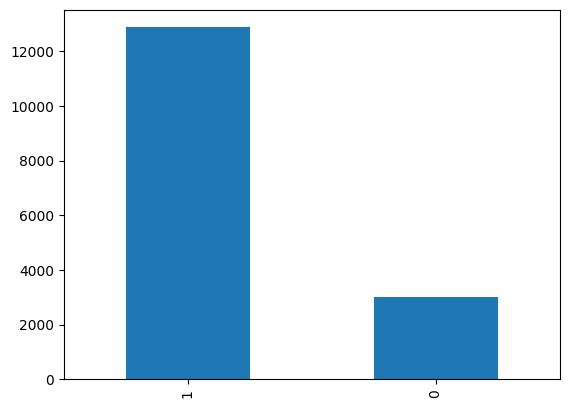

In [7]:
df['category'].value_counts().plot.bar()

# Xem hình ảnh mẫu


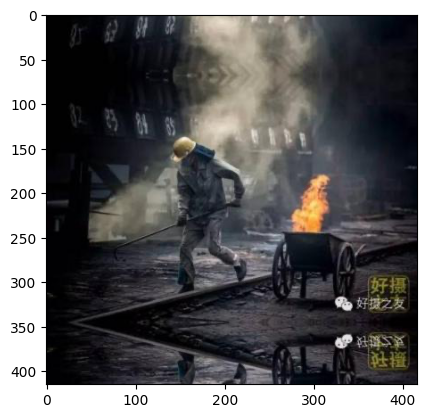

In [8]:
sample = random.choice(filenames)
image = load_img("drive/MyDrive/HocMay/train/"+sample)
plt.imshow(image)

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

# Callbacks

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Dừng sớm**

Để tránh khớp quá mức, chúng tôi sẽ dừng quá trình học sau 10 epoch và giá trị val_loss không giảm

In [11]:
earlystop = EarlyStopping(patience=10)

**Giảm tỷ lệ học tập**

Chúng tôi sẽ giảm tỷ lệ học tập khi độ chính xác không tăng trong 2 bước

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [13]:
callbacks = [earlystop, learning_rate_reduction]

# Prepare data

In [14]:
df["category"] = df["category"].replace({0: 'nohelm', 1: 'helm'}) 

In [15]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: >

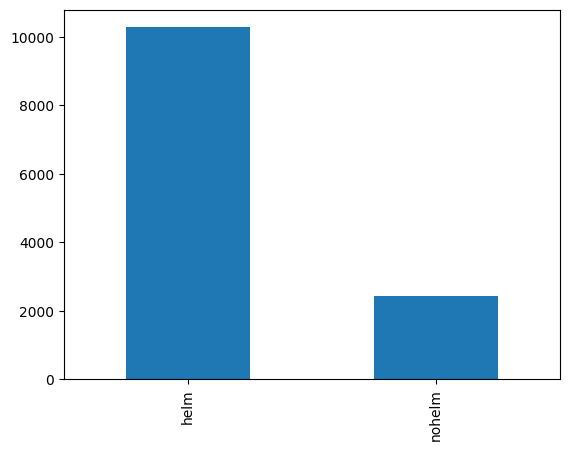

In [16]:
train_df['category'].value_counts().plot.bar()

<Axes: >

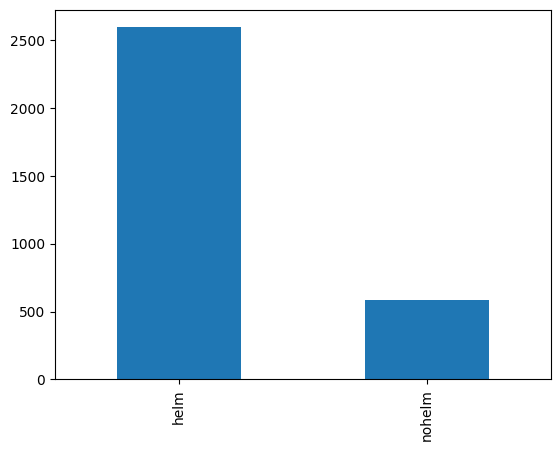

In [17]:
validate_df['category'].value_counts().plot.bar()

In [18]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Training generator


In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "drive/MyDrive/HocMay/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 12717 validated image filenames belonging to 2 classes.


### Trình tạo xác thực

In [20]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "drive/MyDrive/HocMay/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 3180 validated image filenames belonging to 2 classes.


# See how our generator work

In [21]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "drive/MyDrive/HocMay/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


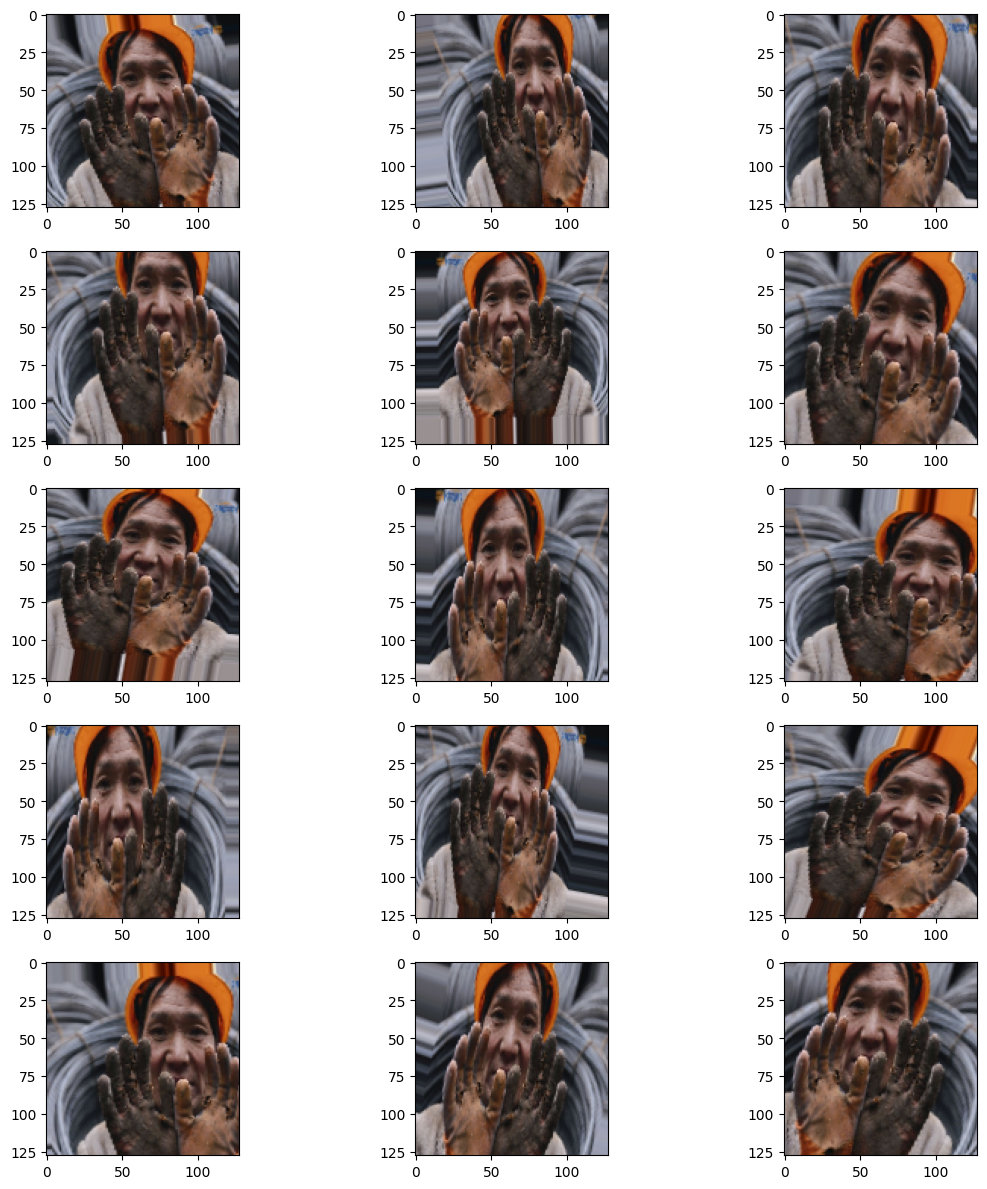

In [22]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Seem to be nice 

# Fit Model

In [23]:
epochs=3 if FAST_RUN else 50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
847/847 [==============================] - ETA: 0s - loss: 0.4627 - accuracy: 0.8355

847/847 [==============================] - 3887s 5s/step - loss: 0.4627 - accuracy: 0.8355 - val_loss: 0.3563 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 2/50
847/847 [==============================] - ETA: 0s - loss: 0.2699 - accuracy: 0.8969

847/847 [==============================] - 589s 695ms/step - loss: 0.2699 - accuracy: 0.8969 - val_loss: 0.2547 - val_accuracy: 0.9179 - lr: 0.0010
Epoch 3/50
847/847 [==============================] - ETA: 0s - loss: 0.2316 - accuracy: 0.9099

847/847 [==============================] - 589s 695ms/step - loss: 0.2316 - accuracy: 0.9099 - val_loss: 0.1923 - val_accuracy: 0.9336 - lr: 0.0010
Epoch 4/50
847/847 [==============================] - ETA: 0s - loss: 0.2124 - accuracy: 0.9220

847/847 [==============================] - 591s 697ms/step - loss: 0.2124 - accuracy: 0.9220 - val_loss: 0.1747 - val_accuracy: 0.9396 - lr: 0.0010
Epoch 5/50
847/847 [==============================] - ETA: 0s - loss: 0.1969 - accuracy: 0.9260

847/847 [==============================] - 584s 689ms/step - loss: 0.1969 - accuracy: 0.9260 - val_loss: 0.2173 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 6/50
847/847 [==============================] - ETA: 0s - loss: 0.1895 - accuracy: 0.9282

847/847 [==============================] - 585s 690ms/step - loss: 0.1895 - accuracy: 0.9282 - val_loss: 0.4371 - val_accuracy: 0.7805 - lr: 0.0010
Epoch 7/50
847/847 [==============================] - ETA: 0s - loss: 0.1764 - accuracy: 0.9362

847/847 [==============================] - 626s 740ms/step - loss: 0.1764 - accuracy: 0.9362 - val_loss: 1.0483 - val_accuracy: 0.8264 - lr: 0.0010
Epoch 8/50
847/847 [==============================] - ETA: 0s - loss: 0.1712 - accuracy: 0.9377

847/847 [==============================] - 595s 702ms/step - loss: 0.1712 - accuracy: 0.9377 - val_loss: 0.1364 - val_accuracy: 0.9522 - lr: 0.0010
Epoch 9/50
847/847 [==============================] - ETA: 0s - loss: 0.1694 - accuracy: 0.9403

847/847 [==============================] - 600s 708ms/step - loss: 0.1694 - accuracy: 0.9403 - val_loss: 0.1257 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 10/50
847/847 [==============================] - ETA: 0s - loss: 0.1648 - accuracy: 0.9404

847/847 [==============================] - 632s 746ms/step - loss: 0.1648 - accuracy: 0.9404 - val_loss: 0.2130 - val_accuracy: 0.9006 - lr: 0.0010
Epoch 11/50
847/847 [==============================] - ETA: 0s - loss: 0.1514 - accuracy: 0.9455

847/847 [==============================] - 592s 697ms/step - loss: 0.1514 - accuracy: 0.9455 - val_loss: 0.1251 - val_accuracy: 0.9550 - lr: 0.0010
Epoch 12/50
847/847 [==============================] - ETA: 0s - loss: 0.1516 - accuracy: 0.9447

847/847 [==============================] - 589s 695ms/step - loss: 0.1516 - accuracy: 0.9447 - val_loss: 0.2391 - val_accuracy: 0.9035 - lr: 0.0010
Epoch 13/50
847/847 [==============================] - ETA: 0s - loss: 0.1499 - accuracy: 0.9460

847/847 [==============================] - 631s 745ms/step - loss: 0.1499 - accuracy: 0.9460 - val_loss: 0.1193 - val_accuracy: 0.9572 - lr: 0.0010
Epoch 14/50
847/847 [==============================] - ETA: 0s - loss: 0.1484 - accuracy: 0.9485

847/847 [==============================] - 584s 689ms/step - loss: 0.1484 - accuracy: 0.9485 - val_loss: 0.1804 - val_accuracy: 0.9239 - lr: 0.0010
Epoch 15/50
847/847 [==============================] - ETA: 0s - loss: 0.1426 - accuracy: 0.9499

847/847 [==============================] - 589s 695ms/step - loss: 0.1426 - accuracy: 0.9499 - val_loss: 0.2464 - val_accuracy: 0.9393 - lr: 0.0010
Epoch 16/50
847/847 [==============================] - ETA: 0s - loss: 0.1330 - accuracy: 0.9528

847/847 [==============================] - 635s 749ms/step - loss: 0.1330 - accuracy: 0.9528 - val_loss: 0.1111 - val_accuracy: 0.9635 - lr: 0.0010
Epoch 17/50
847/847 [==============================] - ETA: 0s - loss: 0.1366 - accuracy: 0.9533

847/847 [==============================] - 644s 760ms/step - loss: 0.1366 - accuracy: 0.9533 - val_loss: 0.1560 - val_accuracy: 0.9387 - lr: 0.0010
Epoch 18/50
847/847 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.9563

847/847 [==============================] - 640s 755ms/step - loss: 0.1296 - accuracy: 0.9563 - val_loss: 1.3564 - val_accuracy: 0.8450 - lr: 0.0010
Epoch 19/50
847/847 [==============================] - ETA: 0s - loss: 0.1366 - accuracy: 0.9537

847/847 [==============================] - 639s 754ms/step - loss: 0.1366 - accuracy: 0.9537 - val_loss: 1.0528 - val_accuracy: 0.8541 - lr: 0.0010
Epoch 20/50
847/847 [==============================] - ETA: 0s - loss: 0.1369 - accuracy: 0.9542

847/847 [==============================] - 603s 712ms/step - loss: 0.1369 - accuracy: 0.9542 - val_loss: 0.4049 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 21/50
847/847 [==============================] - ETA: 0s - loss: 0.1347 - accuracy: 0.9554

847/847 [==============================] - 642s 757ms/step - loss: 0.1347 - accuracy: 0.9554 - val_loss: 0.1101 - val_accuracy: 0.9657 - lr: 0.0010
Epoch 22/50
847/847 [==============================] - ETA: 0s - loss: 0.1266 - accuracy: 0.9582

847/847 [==============================] - 640s 755ms/step - loss: 0.1266 - accuracy: 0.9582 - val_loss: 0.1387 - val_accuracy: 0.9481 - lr: 0.0010
Epoch 23/50
847/847 [==============================] - ETA: 0s - loss: 0.1293 - accuracy: 0.9559

847/847 [==============================] - 601s 710ms/step - loss: 0.1293 - accuracy: 0.9559 - val_loss: 0.1352 - val_accuracy: 0.9575 - lr: 0.0010
Epoch 24/50
847/847 [==============================] - ETA: 0s - loss: 0.1285 - accuracy: 0.9558

847/847 [==============================] - 636s 751ms/step - loss: 0.1285 - accuracy: 0.9558 - val_loss: 0.1491 - val_accuracy: 0.9447 - lr: 0.0010
Epoch 25/50
847/847 [==============================] - ETA: 0s - loss: 0.1311 - accuracy: 0.9573

847/847 [==============================] - 636s 751ms/step - loss: 0.1311 - accuracy: 0.9573 - val_loss: 0.1232 - val_accuracy: 0.9619 - lr: 0.0010
Epoch 26/50
847/847 [==============================] - ETA: 0s - loss: 0.1269 - accuracy: 0.9577

847/847 [==============================] - 597s 704ms/step - loss: 0.1269 - accuracy: 0.9577 - val_loss: 0.1095 - val_accuracy: 0.9632 - lr: 0.0010
Epoch 27/50
847/847 [==============================] - ETA: 0s - loss: 0.1288 - accuracy: 0.9548

847/847 [==============================] - 601s 709ms/step - loss: 0.1288 - accuracy: 0.9548 - val_loss: 0.1804 - val_accuracy: 0.9557 - lr: 0.0010
Epoch 28/50
847/847 [==============================] - ETA: 0s - loss: 0.1316 - accuracy: 0.9573

847/847 [==============================] - 642s 757ms/step - loss: 0.1316 - accuracy: 0.9573 - val_loss: 0.1661 - val_accuracy: 0.9374 - lr: 0.0010
Epoch 29/50
847/847 [==============================] - ETA: 0s - loss: 0.1228 - accuracy: 0.9594

847/847 [==============================] - 638s 754ms/step - loss: 0.1228 - accuracy: 0.9594 - val_loss: 0.1389 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 30/50
847/847 [==============================] - ETA: 0s - loss: 0.1294 - accuracy: 0.9563

847/847 [==============================] - 597s 705ms/step - loss: 0.1294 - accuracy: 0.9563 - val_loss: 0.5660 - val_accuracy: 0.9336 - lr: 0.0010
Epoch 31/50
847/847 [==============================] - ETA: 0s - loss: 0.1308 - accuracy: 0.9558

847/847 [==============================] - 600s 708ms/step - loss: 0.1308 - accuracy: 0.9558 - val_loss: 0.1400 - val_accuracy: 0.9516 - lr: 0.0010
Epoch 32/50
847/847 [==============================] - ETA: 0s - loss: 0.1225 - accuracy: 0.9590

847/847 [==============================] - 596s 704ms/step - loss: 0.1225 - accuracy: 0.9590 - val_loss: 0.1371 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 33/50
847/847 [==============================] - ETA: 0s - loss: 0.1207 - accuracy: 0.9582

847/847 [==============================] - 632s 746ms/step - loss: 0.1207 - accuracy: 0.9582 - val_loss: 0.1854 - val_accuracy: 0.9314 - lr: 0.0010
Epoch 34/50
847/847 [==============================] - ETA: 0s - loss: 0.1186 - accuracy: 0.9584

847/847 [==============================] - 608s 718ms/step - loss: 0.1186 - accuracy: 0.9584 - val_loss: 0.1885 - val_accuracy: 0.9604 - lr: 0.0010
Epoch 35/50
847/847 [==============================] - ETA: 0s - loss: 0.1220 - accuracy: 0.9601

847/847 [==============================] - 605s 714ms/step - loss: 0.1220 - accuracy: 0.9601 - val_loss: 0.1277 - val_accuracy: 0.9560 - lr: 0.0010
Epoch 36/50
847/847 [==============================] - ETA: 0s - loss: 0.1167 - accuracy: 0.9600

847/847 [==============================] - 607s 717ms/step - loss: 0.1167 - accuracy: 0.9600 - val_loss: 0.0877 - val_accuracy: 0.9686 - lr: 0.0010
Epoch 37/50
847/847 [==============================] - ETA: 0s - loss: 0.1111 - accuracy: 0.9613

847/847 [==============================] - 605s 713ms/step - loss: 0.1111 - accuracy: 0.9613 - val_loss: 0.1279 - val_accuracy: 0.9547 - lr: 0.0010
Epoch 38/50
847/847 [==============================] - ETA: 0s - loss: 0.1153 - accuracy: 0.9604

847/847 [==============================] - 605s 714ms/step - loss: 0.1153 - accuracy: 0.9604 - val_loss: 0.1865 - val_accuracy: 0.9425 - lr: 0.0010
Epoch 39/50
847/847 [==============================] - ETA: 0s - loss: 0.1161 - accuracy: 0.9606

847/847 [==============================] - 609s 718ms/step - loss: 0.1161 - accuracy: 0.9606 - val_loss: 0.1091 - val_accuracy: 0.9616 - lr: 0.0010
Epoch 40/50
847/847 [==============================] - ETA: 0s - loss: 0.1117 - accuracy: 0.9621

847/847 [==============================] - 569s 672ms/step - loss: 0.1117 - accuracy: 0.9621 - val_loss: 0.1104 - val_accuracy: 0.9660 - lr: 0.0010
Epoch 41/50
847/847 [==============================] - ETA: 0s - loss: 0.1238 - accuracy: 0.9616

847/847 [==============================] - 607s 716ms/step - loss: 0.1238 - accuracy: 0.9616 - val_loss: 0.0980 - val_accuracy: 0.9682 - lr: 0.0010
Epoch 42/50
847/847 [==============================] - ETA: 0s - loss: 0.1126 - accuracy: 0.9634

847/847 [==============================] - 565s 667ms/step - loss: 0.1126 - accuracy: 0.9634 - val_loss: 0.1918 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 43/50
847/847 [==============================] - ETA: 0s - loss: 0.1196 - accuracy: 0.9617

847/847 [==============================] - 601s 709ms/step - loss: 0.1196 - accuracy: 0.9617 - val_loss: 0.1815 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 44/50
847/847 [==============================] - ETA: 0s - loss: 0.1116 - accuracy: 0.9610

847/847 [==============================] - 560s 661ms/step - loss: 0.1116 - accuracy: 0.9610 - val_loss: 0.1212 - val_accuracy: 0.9635 - lr: 0.0010
Epoch 45/50
847/847 [==============================] - ETA: 0s - loss: 0.1123 - accuracy: 0.9613

847/847 [==============================] - 562s 663ms/step - loss: 0.1123 - accuracy: 0.9613 - val_loss: 0.1181 - val_accuracy: 0.9714 - lr: 0.0010
Epoch 46/50
847/847 [==============================] - ETA: 0s - loss: 0.1075 - accuracy: 0.9644

847/847 [==============================] - 563s 664ms/step - loss: 0.1075 - accuracy: 0.9644 - val_loss: 0.1431 - val_accuracy: 0.9619 - lr: 0.0010


# Save Model

In [24]:
model.save_weights("model.h5")

# Virtualize Training

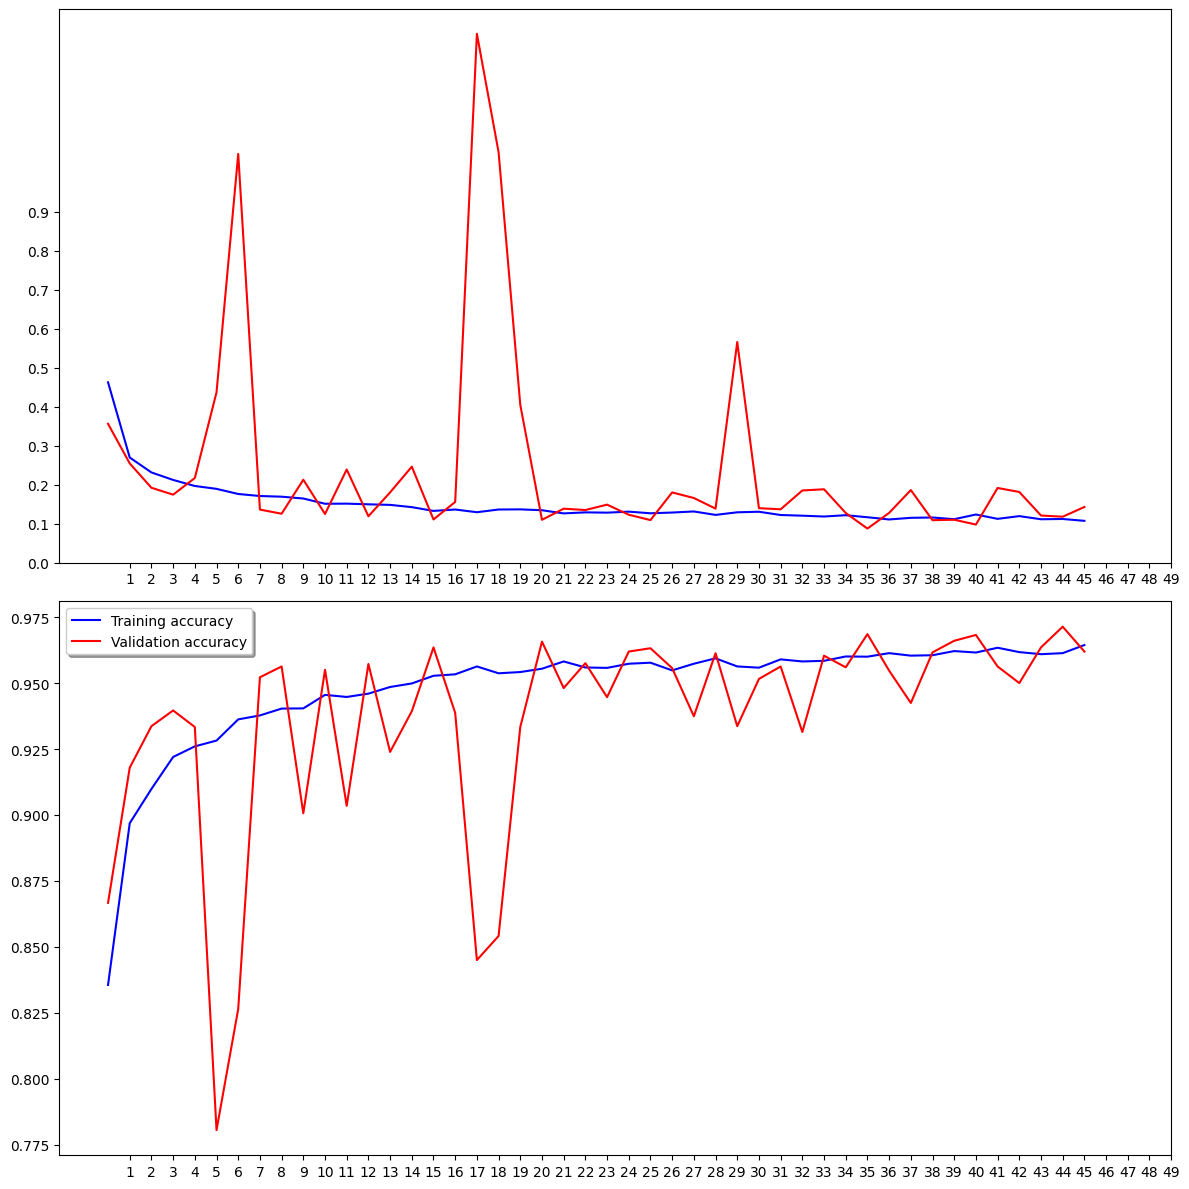

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [43]:
test_filenames = os.listdir("drive/MyDrive/HocMay/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [44]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "drive/MyDrive/HocMay/test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 2261 validated image filenames.


# Predict

In [45]:
# predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))


151/151 [==============================] - 33s 218ms/step


Đối với phân loại theo danh mục, dự đoán sẽ đi kèm với xác suất của từng danh mục. Vì vậy, chúng tôi sẽ chọn danh mục có xác suất cao nhất với tối đa trung bình numpy

In [46]:
test_df['category'] = np.argmax(predict, axis=-1)

Chúng tôi sẽ chuyển đổi danh mục dự đoán trở lại thành các lớp trình tạo của chúng tôi bằng cách sử dụng `train_generator.class_indices`. Đó là các lớp ánh xạ trình tạo hình ảnh trong khi chuyển đổi dữ liệu thành tầm nhìn máy tính

In [47]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [48]:
test_df['category'] = test_df['category'].replace({ 'helm': 1, 'nohelm': 0 })

### Virtaulize Result

<Axes: >

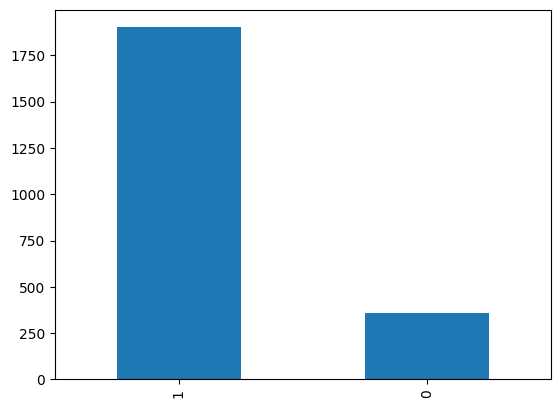

In [49]:
test_df['category'].value_counts().plot.bar()

### Xem kết quả dự đoán với hình ảnh

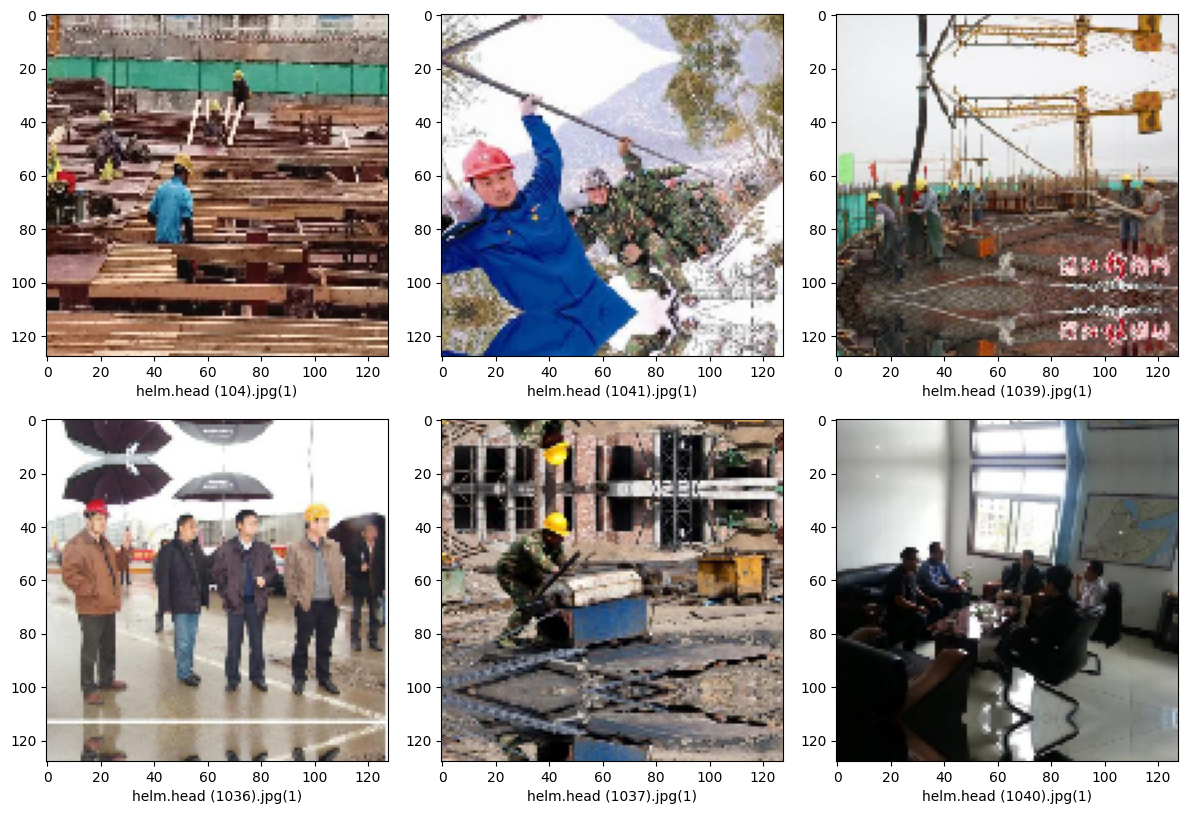

In [53]:
sample_test = test_df.head(6)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("drive/MyDrive/HocMay/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Submission

In [52]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)